In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [70]:
#normalize
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm

#scale back to the true range
def true_range(df, x):
    X = (x * (df['mid1'].max() - df['mid1'].min())) + df['mid1'].min()
    return X

#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#rolling windows
def train_windows(df, ref_day=10, predict_day=5):
    X_train, Y_train = [], []
    for i in range(int(df.shape[0] / 5 - 2)):
        #扣掉response
        #記得最後一行要放response
        #if i == df.shape[0]-predict_day-ref_day -1:
        #    X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        #    Y_train.append(np.array(df.iloc[i+ref_day:]["mid1"]))
        #else:  
        X_train.append(np.array(df.iloc[i * predict_day: predict_day * (i + 2),:-1]))
        Y_train.append(np.array(df.iloc[(i+2) * predict_day: (i+3) * predict_day]["mid1"]))
    return np.array(X_train), np.array(Y_train)

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    #10 -> X shape
    model.add(Dense(10,activation='linear'))
    #5 -> Y shape
    model.add(Dense(5,activation='linear'))
    model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)

#unrealized return    
def unrealized(equity_value_1, unrealized_1):
    idx = []
    for i in range(len(equity_value_1) - 1):
        if (equity_value_1['equity_value'].iloc[i] != equity_value_1['equity_value'].iloc[i+1]) and (equity_value_1['equity_value'].iloc[i+1] != -0.0015):
            idx.append(i+1)
    unrealized_return = pd.DataFrame()
    for i in range(len(idx)):
        if i == 0:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[:idx[i]])])
        else:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[idx[i-1]:idx[i]])])
    return unrealized_return

In [3]:
df = pd.read_csv('./data/3406_2.csv')
#data preprocessing
df['spread1'] = df['Ask1'] - df['Bid1']
df['spread2'] = df['Ask2'] - df['Bid2']
df['spread3'] = df['Ask3'] - df['Bid3']
df['spread4'] = df['Ask4'] - df['Bid4']
df['spread5'] = df['Ask5'] - df['Bid5']
df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
df['a51_diff'] = df['Ask5'] - df['Ask1']
df['b15_diff'] = df['Bid1'] - df['Bid5']
df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
#1 tick
df['da1_dt_1'] = df['Ask1'] - df['Ask1'].shift(1)
df['da2_dt_1'] = df['Ask2'] - df['Ask2'].shift(1)
df['da3_dt_1'] = df['Ask3'] - df['Ask3'].shift(1)
df['da4_dt_1'] = df['Ask4'] - df['Ask4'].shift(1)
df['da5_dt_1'] = df['Ask5'] - df['Ask5'].shift(1)
df['db1_dt_1'] = df['Bid1'] - df['Bid1'].shift(1)
df['db2_dt_1'] = df['Bid2'] - df['Bid2'].shift(1)
df['db3_dt_1'] = df['Bid3'] - df['Bid3'].shift(1)
df['db4_dt_1'] = df['Bid4'] - df['Bid4'].shift(1)
df['db5_dt_1'] = df['Bid5'] - df['Bid5'].shift(1)
#5 ticks
df['da1_dt_5'] = df['Ask1'] - df['Ask1'].shift(5)
df['da2_dt_5'] = df['Ask2'] - df['Ask2'].shift(5)
df['da3_dt_5'] = df['Ask3'] - df['Ask3'].shift(5)
df['da4_dt_5'] = df['Ask4'] - df['Ask4'].shift(5)
df['da5_dt_5'] = df['Ask5'] - df['Ask5'].shift(5)
df['db1_dt_5'] = df['Bid1'] - df['Bid1'].shift(5)
df['db2_dt_5'] = df['Bid2'] - df['Bid2'].shift(5)
df['db3_dt_5'] = df['Bid3'] - df['Bid3'].shift(5)
df['db4_dt_5'] = df['Bid4'] - df['Bid4'].shift(5)
df['db5_dt_5'] = df['Bid5'] - df['Bid5'].shift(5)
##10 ticks
df['da1_dt_10'] = df['Ask1'] - df['Ask1'].shift(10)
df['da2_dt_10'] = df['Ask2'] - df['Ask2'].shift(10)
df['da3_dt_10'] = df['Ask3'] - df['Ask3'].shift(10)
df['da4_dt_10'] = df['Ask4'] - df['Ask4'].shift(10)
df['da5_dt_10'] = df['Ask5'] - df['Ask5'].shift(10)
df['db1_dt_10'] = df['Bid1'] - df['Bid1'].shift(10)
df['db2_dt_10'] = df['Bid2'] - df['Bid2'].shift(10)
df['db3_dt_10'] = df['Bid3'] - df['Bid3'].shift(10)
df['db4_dt_10'] = df['Bid4'] - df['Bid4'].shift(10)
df['db5_dt_10'] = df['Bid5'] - df['Bid5'].shift(10)
#1 tick
df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
#5 ticks
df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
#10 ticks
df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
#response 放在最後一行
df['mid1'] = (df['Ask1'] + df['Bid1']) / 2
#drop nan
df = df.dropna()
df = df.reset_index(drop = True)
#b43_diff_abs and b54_diff_abs are all same values -> drop
#df = df.drop(['b43_diff_abs'], axis = 1)
#df = df.drop(['b54_diff_abs'], axis = 1)
from datetime import datetime
df['TxTime'] = pd.to_datetime(df['TxTime'])
df['TxTime'] = [str(x)[0:10] for x in df['TxTime']]
#some index's ask1 = 0, we change that mid1 to bid1
idx = df[df['Ask1'] == 0].index
for i in idx:
    df['mid1'].iloc[i] = df['Bid1'].iloc[i]
#3/23 3/24 data有缺值 -> drop
df = df[df['TxTime'] != '2020-03-23']
df = df[df['TxTime'] != '2020-03-24']
df = df.reset_index(drop = True)
df['return_10t'] = df['mid1'].shift(-10) / df['mid1'] -1
df['return_10t'] = df['mid1'].shift(-10) / df['mid1'] -1
#1~10 predict 20/10的 return -> 11買賣 -> shift(1)
df['return_10t'] = df['return_10t'].shift(1)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
#後9筆nan drop掉
df = df.iloc[0:493211]
#drop TxTime
df2 = df.drop(['TxTime'], axis = 1)

In [5]:
#patience = 10, batch size = 128(small step)
train_return10 = pd.read_csv('./data/train_return_10_2.csv')
test_return10 = pd.read_csv('./data/test_return_10_2.csv')

In [6]:
#已實現損益
df['equity_value'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
#未實現損益
df['unrealized'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df['holding'] = pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index[:])
df_test = df.iloc[372027: ]
df_train = df.iloc[0:372027]
#0~9 pred 10, hence start from 10
df_train = df_train.iloc[10:, :]
df_test = df_test.iloc[10:, :]
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
#pred return
df_train['pred_return'] = train_return10[['0']]
df_test['pred_return'] = test_return10[['0']]

In [7]:
df_train['5return'] = df_train['mid1'].shift(-4) / df_train['mid1'] -1

In [8]:
df_train['10return'] = df_train['mid1'].shift(-9) / df_train['mid1'] -1

In [9]:
df_train['MA'] = MA(df_train['mid1'], 50)
df_test['MA'] = MA(df_test['mid1'], 50)
df_train = df_train.dropna()
df_train = df_train.reset_index(drop = True)
df_test = df_test.dropna()
df_test = df_test.reset_index(drop = True)
df_train['ma_side'] = df_train['mid1'] > df_train['MA']
df_train['ma_side'] = df_train['ma_side'].astype(int)
df_test['ma_side'] = df_test['mid1'] > df_test['MA']
df_test['ma_side'] = df_test['ma_side'].astype(int)

In [10]:
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,mid1,return_10t,equity_value,unrealized,holding,pred_return,5return,10return,MA,ma_side
0,397.0,1,2,396.5,398.0,1,9,396.0,399.0,142,...,397.25,0.003145,0.0,0.0,0.0,0.001391,0.001259,0.003776,398.000,0
1,0.0,0,2,396.5,398.0,1,9,396.0,399.0,142,...,397.25,0.003776,0.0,0.0,0.0,0.001234,0.001259,0.003776,398.010,0
2,396.5,1,1,396.5,398.0,1,9,396.0,399.0,142,...,397.25,0.003776,0.0,0.0,0.0,0.001335,0.001259,0.003776,398.020,0
3,398.0,1,1,396.5,399.0,142,9,396.0,399.5,6,...,397.75,-0.000629,0.0,0.0,0.0,0.000798,0.000000,-0.001886,398.045,0
4,399.0,1,1,396.5,399.0,141,9,396.0,399.5,6,...,397.75,-0.001886,0.0,0.0,0.0,-0.000094,0.002514,-0.001886,398.070,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371954,0.0,0,4,444.0,445.0,28,11,443.5,445.5,9,...,444.50,0.000000,0.0,0.0,0.0,-0.000119,0.000562,0.000000,444.240,1
371955,0.0,0,1,444.5,445.0,28,4,444.0,445.5,9,...,444.75,0.000000,0.0,0.0,0.0,-0.000140,0.000000,-0.000562,444.250,1
371956,0.0,0,1,444.5,445.0,28,6,444.0,445.5,9,...,444.75,-0.000562,0.0,0.0,0.0,-0.000303,0.000000,-0.000562,444.260,1
371957,0.0,0,1,444.5,445.0,28,6,444.0,445.5,9,...,444.75,-0.000562,0.0,0.0,0.0,-0.000293,-0.000562,-0.000562,444.270,1


In [11]:
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,dbq4_dt_10,dbq5_dt_10,mid1,return_10t,equity_value,unrealized,holding,pred_return,MA,ma_side
0,0.0,0,5,448.0,449.0,32,13,447.5,449.5,12,...,0.0,0.0,448.50,0.000000,0.0,0.0,0.0,-0.000122,447.960,1
1,449.0,1,5,448.0,449.0,31,13,447.5,449.5,12,...,-74.0,-24.0,448.50,0.000000,0.0,0.0,0.0,-0.000118,447.975,1
2,449.0,1,5,448.0,449.0,30,13,447.5,449.5,12,...,-74.0,-24.0,448.50,0.000000,0.0,0.0,0.0,-0.000128,447.990,1
3,0.0,0,5,448.0,449.0,30,14,447.5,449.5,12,...,-74.0,-24.0,448.50,0.000000,0.0,0.0,0.0,-0.000096,448.005,1
4,448.0,1,4,448.0,449.0,30,14,447.5,449.5,12,...,-73.0,-24.0,448.50,0.000000,0.0,0.0,0.0,-0.000083,448.020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121120,0.0,0,39,465.0,466.5,10,49,464.5,467.0,19,...,0.0,0.0,465.75,0.000537,0.0,0.0,0.0,0.000274,465.665,1
121121,0.0,0,40,465.0,466.5,10,49,464.5,467.0,19,...,0.0,0.0,465.75,0.000000,0.0,0.0,0.0,0.000118,465.670,1
121122,0.0,0,10,465.5,466.5,10,40,465.0,467.0,19,...,27.0,-65.0,466.00,0.000000,0.0,0.0,0.0,0.000097,465.675,1
121123,0.0,0,10,465.5,466.0,1,40,465.0,466.5,10,...,27.0,-65.0,465.75,-0.000536,0.0,0.0,0.0,-0.000103,465.685,1


In [12]:
df_train.TxTime.unique()

array(['2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-06', '2020-04-07',
       '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-20', '2020-04-21', '2020-04-22'], dtype=object)

In [14]:
df_test.TxTime.unique()

array(['2020-04-23', '2020-04-24', '2020-04-27', '2020-04-28',
       '2020-04-29', '2020-04-30', '2020-05-04', '2020-05-05'],
      dtype=object)

In [110]:
#setting parameters
import itertools 
long_side, short_side, hard_stop = [0.0015, 0.0017, 0.002], [-0.0015, -0.0017, -0.002], [-0.015, -0.02]
paras = list(itertools.product(long_side, short_side, hard_stop))
paras

[(0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.0017, -0.015),
 (0.0015, -0.0017, -0.02),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.0017, -0.0015, -0.015),
 (0.0017, -0.0015, -0.02),
 (0.0017, -0.0017, -0.015),
 (0.0017, -0.0017, -0.02),
 (0.0017, -0.002, -0.015),
 (0.0017, -0.002, -0.02),
 (0.002, -0.0015, -0.015),
 (0.002, -0.0015, -0.02),
 (0.002, -0.0017, -0.015),
 (0.002, -0.0017, -0.02),
 (0.002, -0.002, -0.015),
 (0.002, -0.002, -0.02)]

In [15]:
paras = [(0.0015, -0.0015)]

In [56]:
#adding hard stop 
#main strategy (train set)
#record transaction
transaction_history1 = {}
#record equity values
equity_value_1 = pd.DataFrame()
#record each returns
#each_return1 = pd.DataFrame()
#record unrealized gain
unrealized_1 = pd.DataFrame()
for l in range(len(paras)):
    df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
    for j in range(len(df_train)):
        if df_train['pred_return'].iloc[j] > paras[l][0]:
            #long side
            df_train['side'].iloc[j] = 1
        elif df_train['pred_return'].iloc[j] < paras[l][1]:
            #short side
            df_train['side'].iloc[j] = -1
    date_idx = df_train['TxTime'].unique()
    #紀錄已實現
    equity_value1 = pd.DataFrame()
    #紀錄未實現
    unrealized1 = pd.DataFrame()
    for k in date_idx:
        df = df_train[df_train.TxTime == k]
        #side = 0
        for i in range(len(df)):
            #first tick
            if i == 0:
                #ask1 may be 0, which means 漲停 (買不到)
                if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                    #side = 1
                    df['holding'].iloc[i] = 1
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = 0
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                    side = 0
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = 0
                elif df['side'].iloc[i] == -1:
                    #side = -1
                    df['holding'].iloc[i] = -1
                    df['equity_value'].iloc[i] = - 0.0015
                    df['unrealized'].iloc[i] = -0.0015
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                else:
                    #side = 0
                    df['holding'].iloc[i] = 0
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = 0
            #last tick
            elif i == (len(df) - 1):
                if df['holding'].iloc[i-1] == 1:
                    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #ask1 may be 0, which means 漲停 (買不到)
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                #收盤如果漲停，空單結不掉，先用mid1結
                elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                    df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                else:
                    df['equity_value'].iloc[i] = 0
                    df['unrealized'].iloc[i] = 0
            else:
                if df['holding'].iloc[i-1] == 1:
                    #hard stop 1 -1 = 0 -> 0
                    #if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                    #    df['holding'].iloc[i] = 0
                    #    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                    #    df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                    #    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side 1 -2 -> -1
                    if (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                        df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - (0.0015 * 2) 
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                elif df['holding'].iloc[i-1] == -1:
                    #hard stop -1 +1 -> 0
                    #if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                    #    df['holding'].iloc[i] = 0
                    #    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                    #    df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    #    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #change side -1 +2 -> 1
                    if (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    else:
                        df['holding'].iloc[i] = df['holding'].iloc[i-1]
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                elif df['holding'].iloc[i-1] == 0:
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif df['side'].iloc[i] == -1:
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015 
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
        equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
        #if k == date_idx[0]:
        unrealized1 = pd.concat([unrealized1, df[['unrealized']]])
        #else:
        #    unrealized_1 = pd.concat([unrealized_1, df['unrealized'] + unrealized_1.iloc[len(unrealized_1) - 1]])
    #concat
    equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
    #each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    
    unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

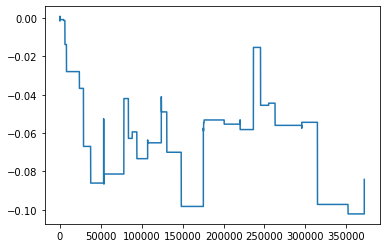

In [57]:
plt.plot(equity_value_1)

In [68]:
def unrealized(equity_value_1, unrealized_1):
    idx = []
    for i in range(len(equity_value_1) - 1):
        if (equity_value_1['equity_value'].iloc[i] != equity_value_1['equity_value'].iloc[i+1]) and (equity_value_1['equity_value'].iloc[i+1] != -0.0015):
            idx.append(i+1)
    unrealized_return = pd.DataFrame()
    for i in range(len(idx)):
        if i == 0:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[:idx[i]])])
        else:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[idx[i-1]:idx[i]])])
    return unrealized_return

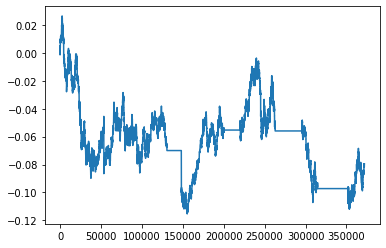

In [71]:
unrealized_return_train = unrealized(equity_value_1, unrealized_1)
plt.plot(unrealized_return_train)

In [21]:
performance(equity_value_1[['equity_value']], transaction_history1[(0.0015, -0.0015)])

return: -0.08305454276321005
std: 0.023832834057768162
sharp ratio: -3.703065382375036
trades: 51.0
odds ratio: 0.39215686274509803
mdd: 0.1031909144364893
skewness: 0.2754188468304398


(-0.08305454276321005,
 0.023832834057768162,
 -3.703065382375036,
 51.0,
 0.39215686274509803,
 0.1031909144364893,
 0.2754188468304398)

In [43]:
transaction_history1[(0.0015, -0.0015)]

[{'Date': '2020-03-25',
  'tick': 0,
  'Action': 1,
  'Price': 397.0,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 58,
  'Action': -1,
  'Price': 398.5,
  'Equity_value': 0.0022783375314861533},
 {'Date': '2020-03-25',
  'tick': 58,
  'Action': -1,
  'Price': 398.5,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 62,
  'Action': 1,
  'Price': 397.5,
  'Equity_value': 0.0025094102885822034},
 {'Date': '2020-03-25',
  'tick': 62,
  'Action': 1,
  'Price': 397.5,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 73,
  'Action': -1,
  'Price': 398.0,
  'Equity_value': -0.00024213836477987452},
 {'Date': '2020-03-25',
  'tick': 73,
  'Action': -1,
  'Price': 398.0,
  'Equity_value': -0.0015},
 {'Date': '2020-03-25',
  'tick': 83,
  'Action': 1,
  'Price': 398.0,
  'Equity_value': -0.0},
 {'Date': '2020-03-25',
  'tick': 83,
  'Action': 1,
  'Price': 398.0,
  'Equity_value': 0},
 {'Date': '2020-03-25',
  'tick': 4421,
  'Action': -1,
  'Price': 399.0,
  'Equity

In [76]:
profit_col = [(0.0015, -0.0015)]

In [78]:
def strategy(df_train, paras):
    #adding hard stop 
    #main strategy (train set)
    #record transaction
    transaction_history1 = {}
    #record equity values
    equity_value_1 = pd.DataFrame()
    #record each returns
    #each_return1 = pd.DataFrame()
    #record unrealized gain
    unrealized_1 = pd.DataFrame()
    for l in range(len(paras)):
        df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
        for j in range(len(df_train)):
            if df_train['pred_return'].iloc[j] > paras[l][0]:
                #long side
                df_train['side'].iloc[j] = 1
            elif df_train['pred_return'].iloc[j] < paras[l][1]:
                #short side
                df_train['side'].iloc[j] = -1
        date_idx = df_train['TxTime'].unique()
        #紀錄已實現
        equity_value1 = pd.DataFrame()
        #紀錄未實現
        unrealized1 = pd.DataFrame()
        for k in date_idx:
            df = df_train[df_train.TxTime == k]
            #side = 0
            for i in range(len(df)):
                #first tick
                if i == 0:
                    #ask1 may be 0, which means 漲停 (買不到)
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        #side = 1
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                        side = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                    elif df['side'].iloc[i] == -1:
                        #side = -1
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        #side = 0
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                #last tick
                elif i == (len(df) - 1):
                    if df['holding'].iloc[i-1] == 1:
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #ask1 may be 0, which means 漲停 (買不到)
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #收盤如果漲停，空單結不掉，先用mid1結
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                        df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    else:
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                else:
                    if df['holding'].iloc[i-1] == 1:
                        #hard stop 1 -1 = 0 -> 0
                        #if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                        #    df['holding'].iloc[i] = 0
                        #    df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        #    df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                        #    transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side 1 -2 -> -1
                        if (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - (0.0015 * 2) 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                    elif df['holding'].iloc[i-1] == -1:
                        #hard stop -1 +1 -> 0
                        #if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                        #    df['holding'].iloc[i] = 0
                        #    df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        #    df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        #    transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side -1 +2 -> 1
                        if (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    elif df['holding'].iloc[i-1] == 0:
                        if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        elif df['side'].iloc[i] == -1:
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = - 0.0015
                            df['unrealized'].iloc[i] = -0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
            equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
            #if k == date_idx[0]:
            unrealized1 = pd.concat([unrealized1, df[['unrealized']]])
            #else:
            #    unrealized_1 = pd.concat([unrealized_1, df['unrealized'] + unrealized_1.iloc[len(unrealized_1) - 1]])
        #concat
        equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
        #each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    
        unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)
    return equity_value_1, unrealized_1, transaction_history1

In [77]:
equity_value_2, unrealized_2 = strategy(df_test,profit_col)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user

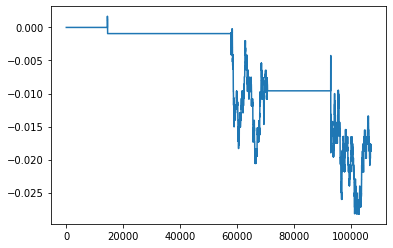

In [79]:
unrealized_return_test = unrealized(equity_value_2, unrealized_2)

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 <a list of 10 Text xticklabel objects>)

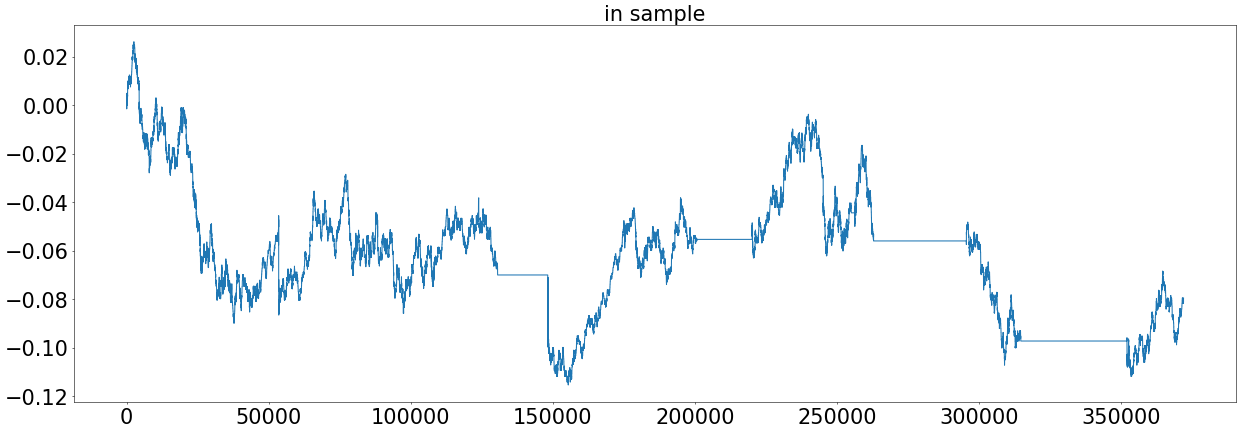

In [82]:
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

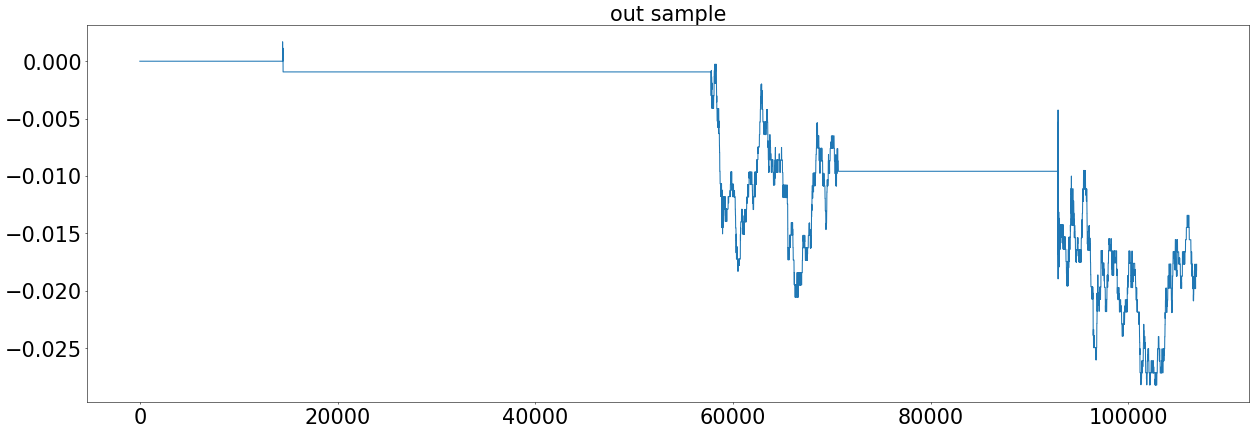

In [81]:
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [24]:
performance(equity_value_2[['equity_value']], transaction_history2[(0.0015, -0.0015)])

return: -0.022190606084223068
std: 0.007607566306737706
sharp ratio: -3.600442635638199
trades: 4.0
odds ratio: 0.0
mdd: 0.022190606084223068
skewness: -0.882215100316061


(-0.022190606084223068,
 0.007607566306737706,
 -3.600442635638199,
 4.0,
 0.0,
 0.022190606084223068,
 -0.882215100316061)

In [ ]:
r_idx = (each_return1.iloc[:, 0][each_return1.iloc[:, 0] != 0]).index.tolist()
#將realized gain補進去
for i in r_idx:
    unrealized_1.iloc[i, 0] = equity_value_1['equity_value'].iloc[i]
r_idx.insert(0,0)
unrealized_df = pd.DataFrame()
for j in range(len(r_idx) - 1):
    unrealized_df = pd.concat([unrealized_df, np.cumsum(unrealized_1.iloc[r_idx[j]:r_idx[j+1], 0])], axis = 0)
unrealized_df = pd.concat([unrealized_df, equity_value_1['equity_value'].iloc[r_idx[-1]:]], axis = 0)
unrealized_df = unrealized_df.reset_index(drop = True)
plt.figure(figsize=(30,10),dpi=50)
#plt.subplot(3, 1, k+1)
plt.plot(unrealized_df)
plt.title(paras, fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
#plt.plot(equity_value_2.iloc[:, k])

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000., 140000.]),
 <a list of 9 Text xticklabel objects>)

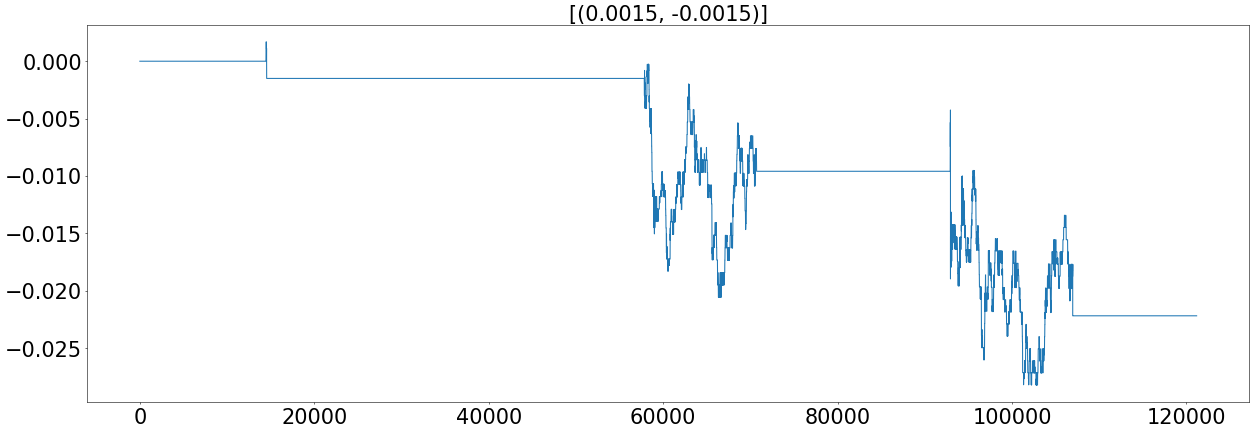

In [69]:
r_idx = (each_return2.iloc[:, 0][each_return2.iloc[:, 0] != 0]).index.tolist()
#將realized gain補進去
for i in r_idx:
    unrealized_2.iloc[i, 0] = equity_value_2['equity_value'].iloc[i]
r_idx.insert(0,0)
unrealized_df = pd.DataFrame()
for j in range(len(r_idx) - 1):
    unrealized_df = pd.concat([unrealized_df, np.cumsum(unrealized_2.iloc[r_idx[j]:r_idx[j+1], 0])], axis = 0)
unrealized_df = pd.concat([unrealized_df, equity_value_2['equity_value'].iloc[r_idx[-1]:]], axis = 0)
unrealized_df = unrealized_df.reset_index(drop = True)
plt.figure(figsize=(30,10),dpi=50)
#plt.subplot(3, 1, k+1)
plt.plot(unrealized_df)
plt.title(profit_col, fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

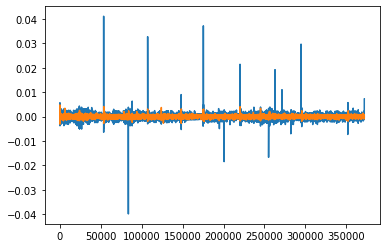

In [71]:
plt.plot(df_train['return_10t'])
plt.plot(df_train['pred_return'])

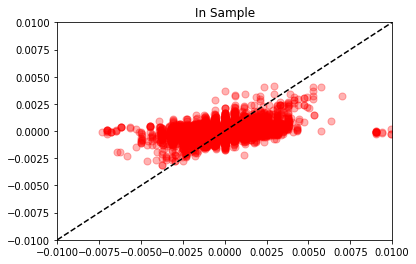

In [12]:
plt.scatter(df_train['return_10t'], df_train['pred_return'], s=50, c='red', alpha=.3)
plt.title('In Sample')
plt.ylim(-0.01, 0.01)
plt.xlim(-0.01, 0.01)
x = [-0.01, 0.01]
plt.plot(x, x, 'k--')

Text(0.5, 1.0, 'Predicted Return (train)')

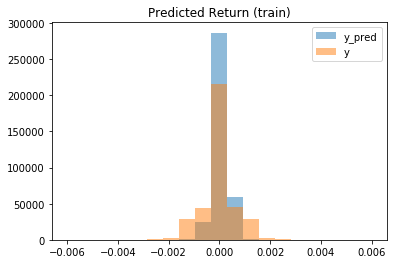

In [46]:
bins = np.linspace(-0.006, 0.006, 20)
plt.hist(df_train['pred_return'], bins, alpha=0.5, label='y_pred')
plt.hist(df_train['return_10t'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title('Predicted Return (train)')

Text(0.5, 1.0, 'Predicted Return (test)')

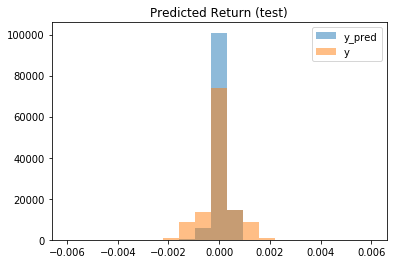

In [47]:
bins = np.linspace(-0.006, 0.006, 20)
plt.hist(df_test['pred_return'], bins, alpha=0.5, label='y_pred')
plt.hist(df_test['return_10t'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title('Predicted Return (test)')

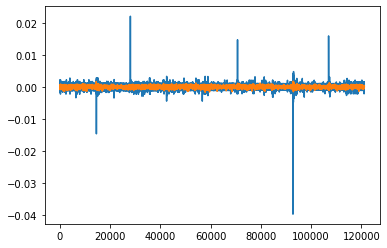

In [80]:
plt.plot(df_test['return_10t'])
plt.plot(df_test['pred_return'])

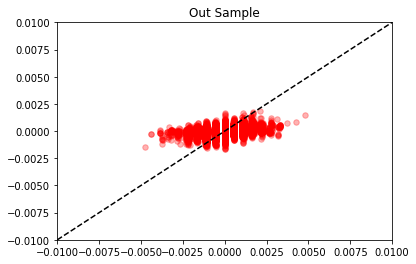

In [13]:
plt.scatter(df_test['return_10t'], df_test['pred_return'], s=30, c='red', alpha=.3)
plt.title('Out Sample')
plt.ylim(-0.01, 0.01)
plt.xlim(-0.01, 0.01)
x = [-0.01, 0.01]
plt.plot(x, x, 'k--')